# Early Prediction of Sepsis from Clinical Data: 
# the PhysioNet/Computing in Cardiology Challenge 2019
8 4 2023
K. Kh

In [7]:
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score


In [8]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
#import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [9]:
combined = pd.read_csv('archive/Dataset.csv')


In [10]:
rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [11]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


In [12]:
df_train = pd.read_csv('data_part1.csv')  # 45 col
df_test = pd.read_csv('data_part2.csv')

In [13]:
df_train.head(15)
df_train.columns
patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [14]:
null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

In [15]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())
df_train_impute.head()

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [16]:
one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

#df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

df_train_impute.head()

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

df_train_impute.head()

# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()


,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,1,0,1,0
1,1,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,2,0,1,0
2,2,-0.407913,0.865243,-1.548869,-3.187955,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,3,0,1,0
3,3,-0.701035,0.865243,-1.548869,-0.251970,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,4,0,1,0
4,4,-0.876908,0.865243,-1.548869,-0.251970,-0.883265,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,5,0,1,0


In [17]:
df_train_impute = df_train_impute.dropna()
null_values = df_train_impute.isnull().mean()*100
null_values

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


In [18]:
def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df


In [19]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [20]:
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
df_train_impute.head()


,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
444732,19,-1.404527,0.244815,-1.025269,-0.471994,-0.883265,0.037457,-0.226541,-0.007482,-0.723147,0.388362,0.584671,-1.118494,0.067044,76.52,-0.02,20,0,0,1
115057,128,2.581930,0.865243,0.169612,0.228970,-0.883265,-1.047984,-1.687828,-1.262219,-0.072804,-1.463184,-1.300600,1.838784,0.922524,53.20,-155.52,129,0,1,0
696110,3,1.526691,0.865243,-0.729905,-0.547377,1.341920,-0.042867,0.504102,0.341885,0.258347,-0.475692,0.054438,-0.810513,-0.195173,71.74,-0.03,7,0,0,1
117489,15,-1.814898,-0.065399,-1.105823,1.134416,1.341920,1.083251,0.869424,-0.718959,1.687754,0.408935,0.054438,0.334781,0.608265,64.50,-0.05,16,0,1,0
57134,36,-0.407913,-0.065399,0.008505,1.812292,0.229328,-0.762476,-0.774524,-0.560343,1.180994,1.437572,1.350562,-0.928944,0.036129,55.93,-0.02,38,0,0,1


In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36681, 19)
(36681,)
(9171, 19)
(9171,)


In [23]:
# ANN
model = Sequential()

# layers
model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 19))
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # categorical_crossentropy binary_crossentropy

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 64, epochs = 200, validation_split=0.25)

Epoch 1/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5637 - accuracy: 0.7378 - val_loss: 0.5372 - val_accuracy: 0.7380
Epoch 2/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5360 - accuracy: 0.7526 - val_loss: 0.5330 - val_accuracy: 0.7432
Epoch 3/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5302 - accuracy: 0.7541 - val_loss: 0.5305 - val_accuracy: 0.7429
Epoch 4/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5236 - accuracy: 0.7583 - val_loss: 0.5226 - val_accuracy: 0.7599
Epoch 5/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5178 - accuracy: 0.7605 - val_loss: 0.5134 - val_accuracy: 0.7592
Epoch 6/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5116 - accuracy: 0.7610 - val_loss: 0.5126 - val_accuracy: 0.7561
Epoch 7/200
430/430 [==============================] - 1s 2ms/step - loss: 0.5076 - accuracy: 0.7639 - val_loss: 0.5095 - val_accuracy: 0.7611


val_accuracy is: 84.17%


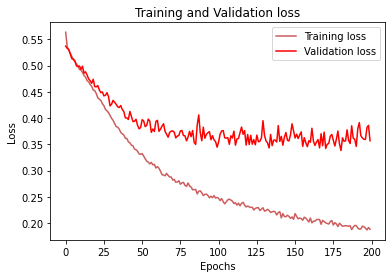

In [24]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

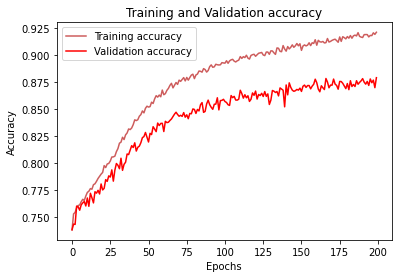

In [25]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

287/287 [==============================] - 0s 746us/step


<Axes: >

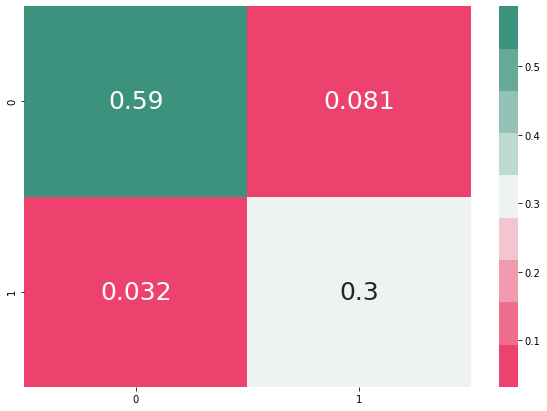

In [26]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.4)
np.set_printoptions()

# Getting the confusion matrix
cmap1 = sns.diverging_palette(2, 165, s=80, l=55, n=9)
plt.subplots(figsize=(10,7))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':25})

In [27]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.88      0.91      6134
           1       0.79      0.90      0.84      3037

    accuracy                           0.89      9171
   macro avg       0.87      0.89      0.88      9171
weighted avg       0.89      0.89      0.89      9171



Accuracy: 0.957801766437684
Precision: 0.9232981783317353
Recall: 0.9515810276679841
F1 Score: 0.9372262773722627
AUC-ROC: 0.9562306116335031
Mean Absolute Error: 0.042198233562315994
Root Mean Squared Error: 0.20542208635469555


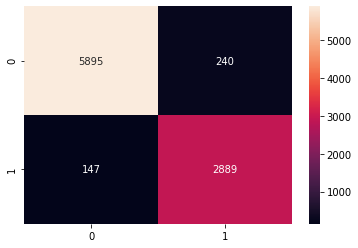

In [23]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
hist=model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

evaluate_model(y_test,rcf_predictions)



Accuracy: 0.8807245616159985
Precision: 0.1032183908045977
Recall: 0.45839714139867277
F1 Score: 0.16849610657660194
AUC-ROC: 0.6752786281991981
Mean Absolute Error: 0.11927543838400151
Root Mean Squared Error: 0.34536276345894834


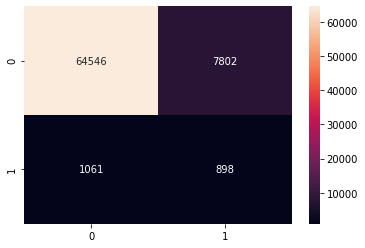

In [29]:
df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)


In [30]:
print(classification_report(y, rcf_predictions))


              precision    recall  f1-score   support

           0       0.98      0.89      0.94     72348
           1       0.10      0.46      0.17      1959

    accuracy                           0.88     74307
   macro avg       0.54      0.68      0.55     74307
weighted avg       0.96      0.88      0.92     74307

